In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")

print("Path to dataset files:", path)

100%|██████████| 107M/107M [00:00<00:00, 264MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1


## Custom Dataset Class

In [8]:
import os
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import glob
# Custom Dataset Class
class FloodSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.target_transform = target_transform
        assert len(self.image_paths) == len(self.mask_paths) # "Number of images and masks must match"


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert("RGB") # cus I'll use pretrained model
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

In [9]:
image_paths = sorted(glob.glob(os.path.join(path, "Image", "*.jpg")))
mask_paths = sorted(glob.glob(os.path.join(path, "Mask", "*.png")))

assert len(image_paths) == len(mask_paths)

## Splitting into train & test

In [10]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    image_paths, mask_paths,
    test_size=0.2,    # 80% train, 20% test
    random_state=42,
    shuffle=True
)

In [11]:
# Defining the transformation

image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])


In [12]:
#Creating the dataset and dataloader

from torch.utils.data import DataLoader

train_dataset = FloodSegmentationDataset(train_imgs, train_masks, image_transforms, mask_transforms)
test_dataset = FloodSegmentationDataset(test_imgs, test_masks, image_transforms, mask_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

Train size: 232, Test size: 58


### Let's display some images

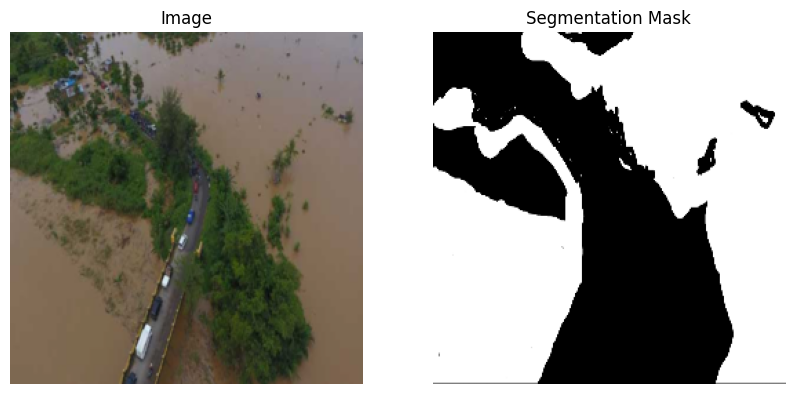

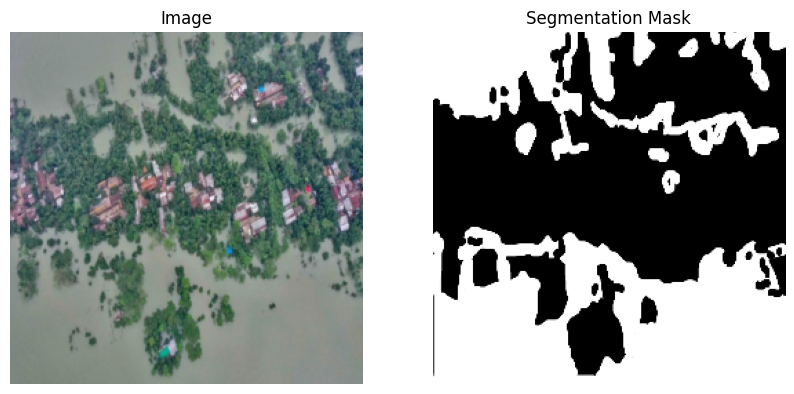

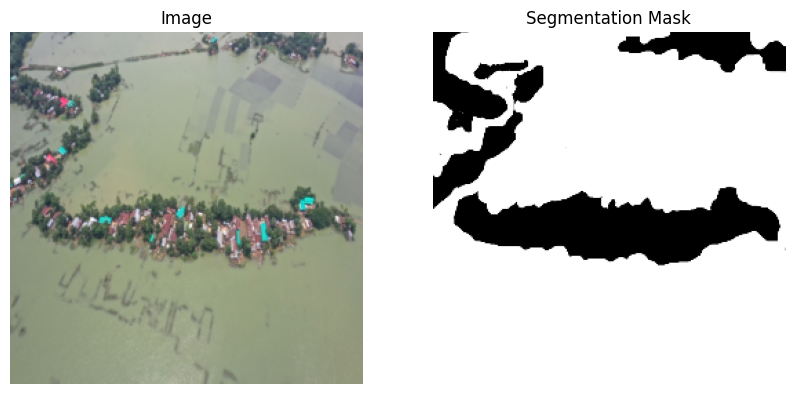

In [13]:
import matplotlib.pyplot as plt
import numpy as np
# Function to denormalize images (We cannot show normalized images. We have to reverse normalizaion first.)
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC
    img = img * std + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Clip values to [0,1]
    return img

# Display some images with their masks
for i in range(3):
    img, mask = train_dataset[i]
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(denormalize(img))
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(mask.squeeze(), cmap="gray")
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")
    plt.show()

## Model Class

In [14]:
!pip install -q segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.0 MB/s eta 0:00:00


In [15]:
import segmentation_models_pytorch as smp

# Define U-Net Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(
    encoder_name="efficientnet-b0",  # Pretrained encoder (backbone)
    encoder_weights="imagenet",  # Use ImageNet weights
    in_channels=3,  # RGB images
    classes=1,  # Binary segmentation (1 output channel)
    activation="sigmoid"  # Apply Sigmoid activation directly in the model
).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

## Training and Validation Loops

In [16]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [17]:
import torch
from torch import nn
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

num_epochs = 10  # Define number of epochs
train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Epoch 1/10: Train Loss = 0.6171, Val Loss = 0.5825


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch 2/10: Train Loss = 0.5175, Val Loss = 0.5036


100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Epoch 3/10: Train Loss = 0.4542, Val Loss = 0.4497


100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


Epoch 4/10: Train Loss = 0.3978, Val Loss = 0.4272


100%|██████████| 15/15 [00:09<00:00,  1.67it/s]


Epoch 5/10: Train Loss = 0.3570, Val Loss = 0.4094


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 6/10: Train Loss = 0.3142, Val Loss = 0.3923


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


Epoch 7/10: Train Loss = 0.2864, Val Loss = 0.3543


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch 8/10: Train Loss = 0.2659, Val Loss = 0.3397


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epoch 9/10: Train Loss = 0.2443, Val Loss = 0.3048


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epoch 10/10: Train Loss = 0.2336, Val Loss = 0.3086


## Plot Training Loss Curve


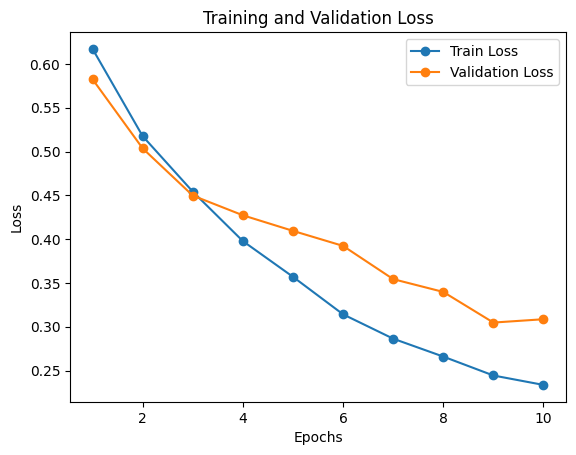

In [18]:
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Visualizing Predictions

- By comparing **predicted flood masks** against **ground truth masks**.
-  visualizing the results for multiple test images.

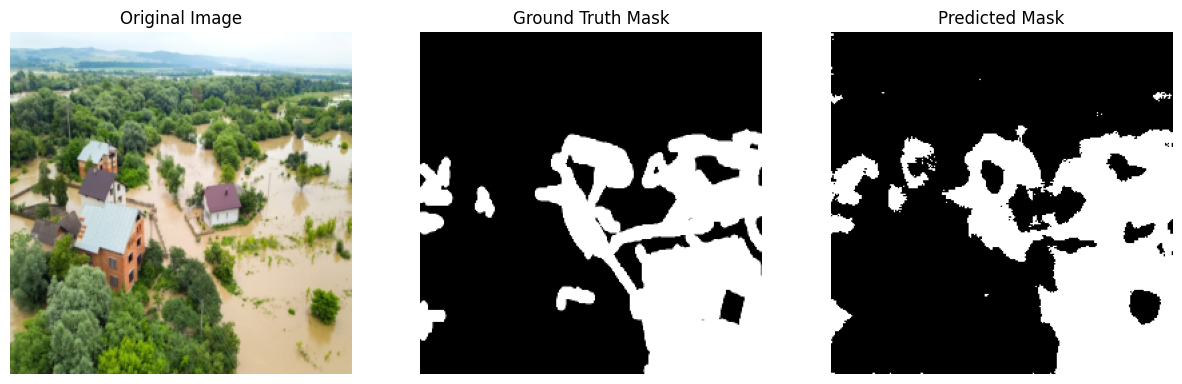

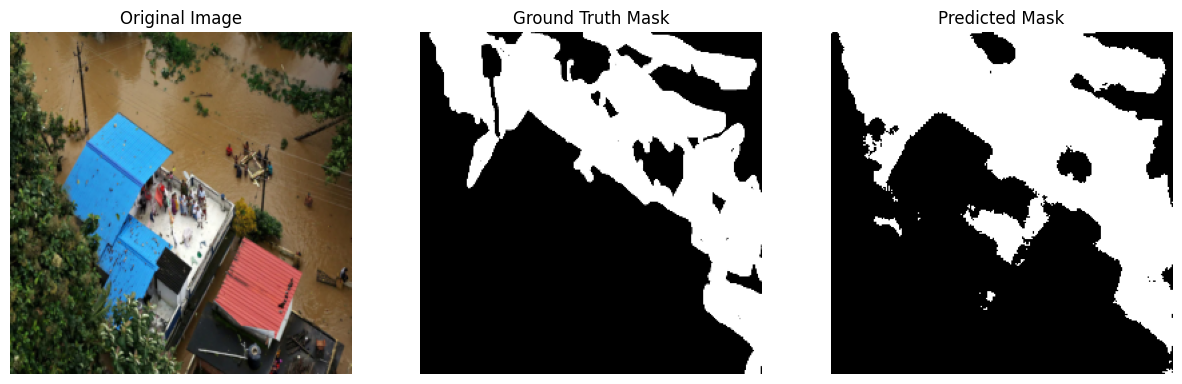

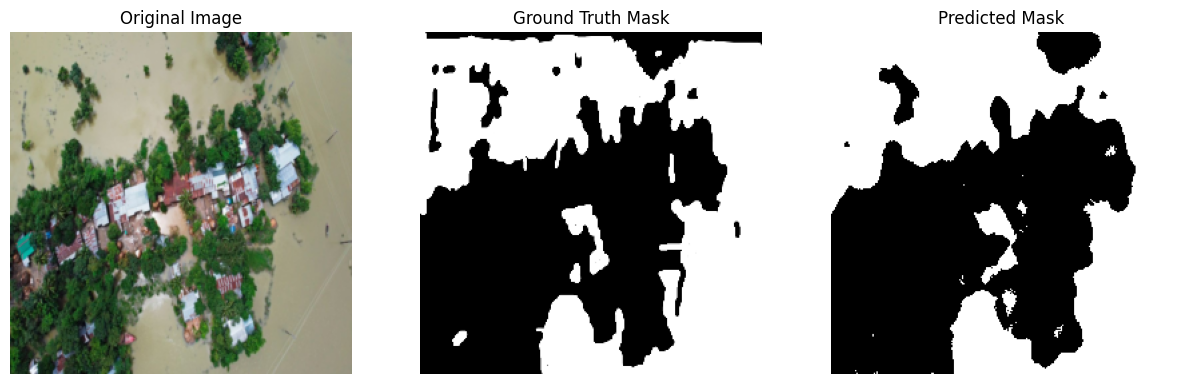

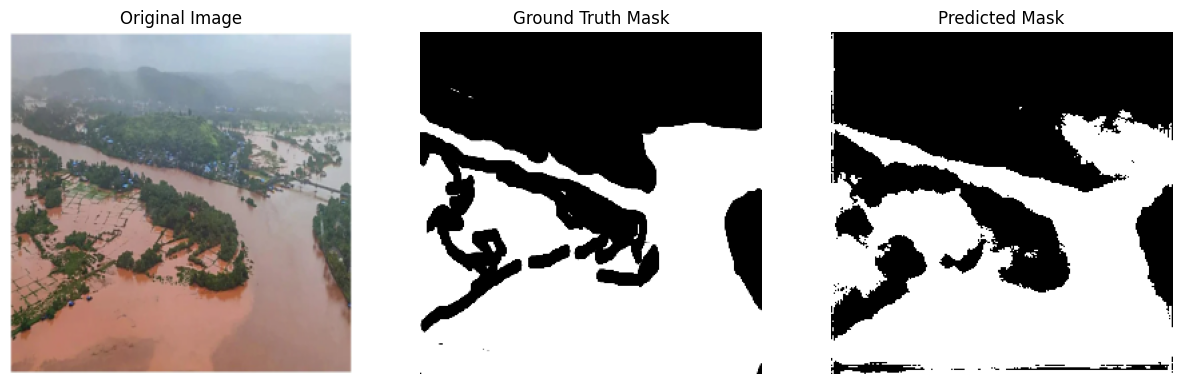

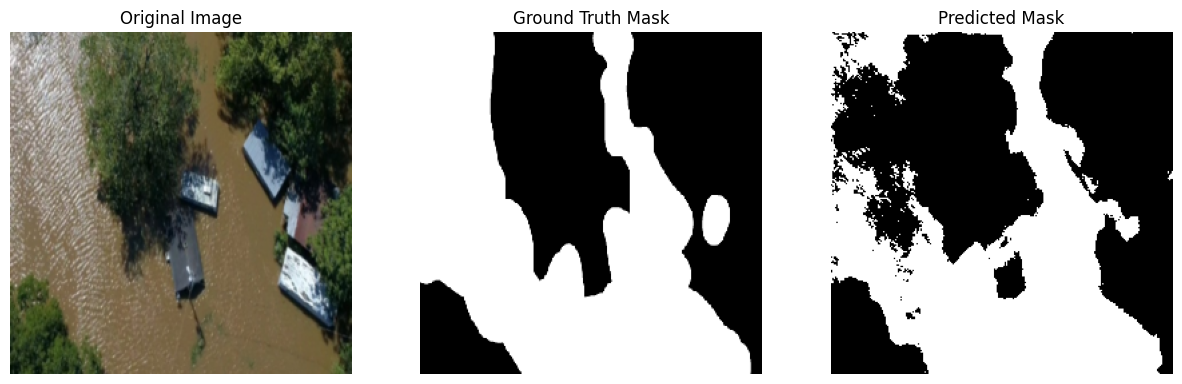

In [19]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize images
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC
    img = img * std + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Clip values to [0,1]
    return img

# Set model to evaluation mode
model.eval()

# Get some test samples
test_samples = random.sample(range(len(test_dataset)), 5)

for idx in test_samples:
    img, mask = test_dataset[idx]

    with torch.no_grad():
        pred_mask = model(img.unsqueeze(0).to(device))  # Forward pass

    pred_mask = (pred_mask >= 0.5).cpu().squeeze().numpy()  # Convert to binary mask

    # Display images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image (Denormalized)
    axes[0].imshow(denormalize(img))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Ground Truth Mask
    axes[1].imshow(mask.squeeze(), cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    # Predicted Mask
    axes[2].imshow(pred_mask, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

# ☆*: .｡. o(≧▽≦)o .｡.:*☆ 🚀🚀
